---
# Imports

In [1]:
import random

import pandas as pd

import torch
from torch.utils.data import DataLoader, TensorDataset, Subset
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler



from utils.data_utils_new import scale_data_per_country_new
from utils.model_utils_new import StackedLSTM_new, init_weights

In [2]:
def get_pd_from_pkl(path: str) -> pd.DataFrame:
    df = pd.read_pickle(path)
    return df
# df = get_pd_from_pkl(path=r"data\training_data\training_added_feats_no_hospital.pkl")
# df_og = get_pd_from_pkl(path="data/training_data/training_datav2_0-weekly.pkl")
# df.head()

df_og = get_pd_from_pkl(path="data/training_data/training_datav2_0-weekly.pkl")
df_policies = get_pd_from_pkl(path=r"data\all_policies\policies_individual_final.pkl")
df_vaccines = get_pd_from_pkl(path=r"data\timeseries_pickles\additional_features\better_vaccine_data.pkl")

In [3]:
#MERGE DATAFRAMES

df_vaccines_policies = pd.merge(left=df_vaccines, right=df_policies, how="inner", 
                                on=["location", "date"])
df_vaccines_policies = df_vaccines_policies.sort_values(by=["location", "date"])
df_og = df_og.sort_values(by=["location", "date"])
df_vaccines_policies['new_cases'] = df_og['new_cases']
df = df_vaccines_policies.copy()

In [4]:
# # Load the pickle file
# file_path = "data/training_data/training_datav2_0-weekly.pkl"
# df = pd.read_pickle(file_path)

# # Display the first few rows of the DataFrame
# df.head()

---
# Prepare data

In [5]:
def get_all_but_one_data_new(target_country: str, df: pd.DataFrame, 
                         endog_columns: list, policy_columns: list, target_column: str):
    
    full_data = df.dropna().copy()
    full_data = full_data[['location', 'C', 'E', 'G', 'S', 'weekly_deaths', 'weekly_cases']]
    full_data.loc[:, 'target'] = full_data['weekly_cases']
    
    train_data = full_data[full_data['location'] != target_country].copy()
    test_data = full_data[full_data['location'] == target_country].copy()
    
    y_train, X_train_endog, X_train_exog = scale_data_per_country_new(
                                        df=train_data, endog_columns=endog_columns,
                                        policy_columns=policy_columns,
                                        countries=list(train_data['location'].unique()),
                                        target_column=target_column, scaler=MinMaxScaler()
                                        )
    y_test, X_test_endog, X_test_exog = scale_data_per_country_new(
                                        df=test_data, endog_columns=endog_columns,
                                        policy_columns=policy_columns,
                                        countries=list(test_data['location'].unique()),
                                        target_column=target_column, scaler=MinMaxScaler(),
                                        seq_length=4
                                        )
    
    return X_train_endog, X_train_exog, y_train, X_test_endog, X_test_exog, y_test
    

In [6]:
def get_data_laoders(X_train, y_train, X_test, y_test, device, batch_size = 32):
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1).to(device)

    # Create DataLoader
    batch_size = 64
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

In [7]:
df.columns

Index(['total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
       'location', 'date', 'c1m', 'c2m', 'c3m', 'c4m', 'c5m', 'c6m', 'c7m',
       'c8ev', 'e1', 'e2', 'h1', 'h2', 'h3', 'h6m', 'h7', 'h8m', 'new_cases'],
      dtype='object')

In [8]:
original_columns = ['location', 'date', 'weekly_cases', 'C', 'E', 'G', 'S',
       'biweekly_cases', 'biweekly_deaths', 'new_cases', 'new_deaths',
       'total_cases', 'total_deaths', 'weekly_deaths',
       'daily_vaccinations_per_million', 'total_vaccinations_per_hundred',
       'Weekly new ICU admissions', 'Weekly new ICU admissions per million',
       'Weekly new hospital admissions',
       'Weekly new hospital admissions per million']

used_columns = ['location', 'date', 'weekly_cases', 'C', 'E', 'G', 'S',
       'total_vaccinations_per_hundred', 'daily_vaccinations_per_million']

extra_not_use_columns = list(set(original_columns) - set(used_columns))

In [9]:
info_columns = ['location', 'date']
endog_columns = ['new_cases']
exog_columns = ['c1m', 'c2m', 'c3m', 'c4m', 'c5m', 'c6m', 'c7m',
       'c8ev', 'e1', 'e2', 'h1', 'h2', 'h3', 'h6m', 'h7', 'h8m',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',]
features_to_test = info_columns + endog_columns + exog_columns

In [10]:
full_data = df[features_to_test].dropna().copy()
# full_data = full_data[['location', 'C', 'E', 'G', 'S', 'weekly_deaths', 'weekly_cases']]
#per afegir noves features
# full_data = full_data[features]
full_data.loc[:, 'target'] = full_data['new_cases']

# Filter out locations that appear less than 20 times
location_counts = full_data['location'].value_counts()
valid_locations = location_counts[location_counts >= 20].index
full_data = full_data[full_data['location'].isin(valid_locations)]

In [11]:
target_country = "spain"

In [12]:
random.seed(42)  # Set the random seed for reproducibility
target_country = random.sample(list(full_data.location.unique()), int(full_data.location.nunique()*0.25))
target_country = ['Latvia']

In [13]:
train_data = full_data[~full_data['location'].isin(target_country)].copy()
# train_data = train_data.loc[~train_data['location'].isin(['luxembourg', 'cyprus'])]
test_data = full_data[full_data['location'].isin(target_country)].copy()
# test_data = test_data.loc[~test_data['location'].isin(['luxembourg', 'cyprus'])]

if train_data.empty or test_data.empty:
    raise ValueError("Empty data!")

In [14]:
# feature_columns = ['C', 'E', 'G', 'S', 'weekly_deaths', 'weekly_cases']
# feature_columns = [col for col in df.columns if col not in ['location', 'date', 'weekly_cases', 'weekly_deaths', 'target'] + extra_not_use_columns] 
target_column = "target"
endog_columns = endog_columns
policy_columns = exog_columns
seq_length = 2
#Get Train data

from sklearn.preprocessing import MinMaxScaler

# Define and fit scalers on training data
scaler_X_train = MinMaxScaler()
scaler_y_train = MinMaxScaler()

scaler_X_train.fit(train_data[endog_columns + policy_columns])
scaler_y_train.fit(train_data[[target_column]])

# Use these scalers in your data preparation
y_train, X_endog_train, X_exog_train = scale_data_per_country_new(
    df=train_data,
    feature_columns=endog_columns + policy_columns,
    endog_columns=endog_columns,
    policy_columns=policy_columns,
    countries=list(train_data['location'].unique()),
    target_column=target_column,
    scaler=scaler_y_train,  # This is important
    seq_length=seq_length
)

# Use the already-fitted scaler on test data
y_test, X_endog_test, X_exog_test = scale_data_per_country_new(
    df=test_data,
    feature_columns=endog_columns + policy_columns,
    endog_columns=endog_columns,
    policy_columns=policy_columns,
    countries=list(test_data['location'].unique()),
    target_column=target_column,
    scaler=scaler_y_train,  # same scaler as above
    seq_length=seq_length
)



In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [16]:
# Convert to PyTorch tensors
X_train_tensor_endog = torch.tensor(X_endog_train, dtype=torch.float32).to(device)
X_train_tensor_exog = torch.tensor(X_exog_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1).to(device)
X_test_tensor_endog = torch.tensor(X_endog_test, dtype=torch.float32).to(device)
X_test_tensor_exog = torch.tensor(X_exog_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1).to(device)

# Create DataLoader
batch_size = 64
train_dataset = TensorDataset(X_train_tensor_endog, X_train_tensor_exog, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor_endog, X_test_tensor_exog, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

---
# Training

## Training utils

In [17]:
def init_model(num_endog_features:int, num_exog_features:int, 
               hidden_size:int, num_layers:int, output_size:int, dropout: float) -> nn.Module:
    """Instantiates the model and initializes weights.
    The model is a stacked LSTM with the specified input size, 
    hidden size, number of layers, and output size.

    Args:
        input_size (int): Input size to the LSTM layer.
        hidden_size (int): Hidden size of the LSTM layer.
        num_layers (int): Number of LSTM layers.
        output_size (int): Output size of the model.

    Returns:
        nn.Module: The initialized model.
    """
    model = StackedLSTM_new(num_endog_features=num_endog_features, 
                    num_exog_features=num_exog_features, 
                    hidden_size=hidden_size, 
                    num_layers=num_layers, 
                    output_size=output_size, 
                    dropout=dropout)
    model.apply(init_weights)
    return model.to(device)

## Training exec

In [18]:
# input_size= X_train.shape[2]
hidden_size=64
num_layers=3
output_size=1
learning_rate=0.01
weight_decay = 1e-4
dropout = 0.2
num_endog_features = X_train_tensor_endog.shape[2]
num_exog_features = len(policy_columns)
model = init_model(num_endog_features , num_exog_features, 
               hidden_size=hidden_size, num_layers=num_layers, 
               output_size=output_size, dropout=dropout) 
# model = init_model(input_size, hidden_size, num_layers, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [19]:
normal = False

### normal training loop

In [20]:
if normal:
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error
    import numpy as np

    # Initialize training parameters
    num_epochs = 100 # Adjust as needed
    print_every = 10  # Set how often to print

    # Store losses
    train_losses = []
    val_losses = []  # This will now store RMSE on test set per epoch

    # Start training
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        # Only keep predictions and inputs from the last epoch
        if epoch == num_epochs - 1:
            predictions_last = []
            actuals_last = []
            inputs_last = []

        # Training loop
        for batch_idx, (X_endog_batch, X_exog_batch, y_batch) in enumerate(train_loader):
            X_endog_batch = X_endog_batch.to(device)
            X_exog_batch = X_exog_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_endog_batch, X_exog_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            print(X_endog_batch.shape, X_exog_batch.shape, y_batch.shape, y_pred.shape)
            break
            if epoch == num_epochs - 1:
                predictions_last.extend(y_pred.cpu().detach().numpy())
                actuals_last.extend(y_batch.cpu().numpy())
                inputs_last.extend(X_endog_batch.cpu().numpy())

        # Compute average training loss
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # --- RMSE Validation loop on test set ---
        model.eval()
        test_predictions = []
        test_actuals = []

        with torch.no_grad():
            for X_endog_val, X_exog_val, y_val in test_loader:
                X_endog_val = X_endog_val.to(device)
                X_exog_val = X_exog_val.to(device)
                y_val = y_val.to(device)

                y_pred = model(X_endog_val, X_exog_val)
                test_predictions.extend(y_pred.cpu().numpy().flatten())
                test_actuals.extend(y_val.cpu().numpy().flatten())

        # Compute RMSE as validation loss
        rmse_val = np.sqrt(mean_squared_error(test_actuals, test_predictions))
        val_losses.append(rmse_val)

        # Print losses
        if (epoch + 1) % print_every == 0 or epoch == num_epochs - 1:
            print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, RMSE (Test): {rmse_val:.4f}")


### auto-forcing training loop

In [21]:
if normal:
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error
    import numpy as np
    import torch
    import torch.nn as nn
    import math

    # Initialize training parameters
    num_epochs = 200
    print_every = 10
    def get_teacher_forcing_prob(epoch, num_epochs, alpha=5, type_prob = 'exp', decay_rate=0.05):
        """Linear decay of teacher forcing ratio."""        
        if type_prob == "linear":
            return max(final_teacher_forcing_prob, 
                initial_teacher_forcing_prob - (epoch / num_epochs) * (initial_teacher_forcing_prob - final_teacher_forcing_prob))
        elif type_prob == "exp":
            return math.exp(-decay_rate * epoch)
        elif type_prob == "exp_decay":
            decay = np.exp(-alpha * epoch / num_epochs)
            max_decay = np.exp(-alpha * 0 / num_epochs)  # = 1
            min_decay = np.exp(-alpha * (num_epochs - 1) / num_epochs)  # ~ small value
            norm_decay = (decay - min_decay) / (max_decay - min_decay)
            return final_teacher_forcing_prob + (initial_teacher_forcing_prob - final_teacher_forcing_prob) * norm_decay
    # Scheduled Sampling Parameters
    initial_teacher_forcing_prob = 1.0  # start with full teacher forcing
    final_teacher_forcing_prob = 0.0   # end with full autoregression


    # Store losses
    train_losses = []
    val_losses = []

    teacher_forcing_ratios = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        tf_ratio = get_teacher_forcing_prob(epoch, num_epochs, type_prob = 'exp_decay', alpha=0.5)
        teacher_forcing_ratios.append(tf_ratio)
        
        for batch_idx, (X_endog_batch, X_exog_batch, y_batch) in enumerate(train_loader):
            X_endog_batch = X_endog_batch.to(device)  # shape: [batch, seq_len, 1] (weekly_cases only)
            X_exog_batch = X_exog_batch.to(device)
            y_batch = y_batch.to(device)

            batch_size, seq_len, _ = X_endog_batch.size()

            # Initialize input for autoregression
            input_seq = X_endog_batch.clone()

            for t in range(1, seq_len):
                use_teacher = np.random.rand() < tf_ratio

                if not use_teacher:
                    with torch.no_grad():
                        # Feed previous prediction as input instead of ground truth
                        prev_input = input_seq[:, :t, :]
                        prev_exog = X_exog_batch  # assuming exog remains fixed per sample
                        pred = model(prev_input, prev_exog)
                        pred = pred.unsqueeze(1)  # [batch, 1, 1]

                        input_seq[:, t, :] = pred.squeeze(1)  # Replace t-th input with model's prediction

            optimizer.zero_grad()
            y_pred = model(input_seq, X_exog_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation (no scheduled sampling, just standard inference)
        model.eval()
        test_predictions = []
        test_actuals = []

        with torch.no_grad():
            for X_endog_val, X_exog_val, y_val in test_loader:
                X_endog_val = X_endog_val.to(device)
                X_exog_val = X_exog_val.to(device)
                y_val = y_val.to(device)

                y_pred = model(X_endog_val, X_exog_val)
                test_predictions.extend(y_pred.cpu().numpy().flatten())
                test_actuals.extend(y_val.cpu().numpy().flatten())

        rmse_val = np.sqrt(mean_squared_error(test_actuals, test_predictions))
        val_losses.append(rmse_val)

        if (epoch + 1) % print_every == 0 or epoch == num_epochs - 1:
            print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, RMSE (Test): {rmse_val:.4f}, Teacher Forcing: {tf_ratio:.2f}")


In [22]:
if not normal:
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error
    import numpy as np
    import torch
    import torch.nn as nn
    import math
    def get_teacher_forcing_prob(epoch, num_epochs, alpha=5, type_prob = 'exp', decay_rate=0.05):
        """Linear decay of teacher forcing ratio."""        
        if type_prob == "linear":
            return max(final_teacher_forcing_prob, 
                initial_teacher_forcing_prob - (epoch / num_epochs) * (initial_teacher_forcing_prob - final_teacher_forcing_prob))
        elif type_prob == "exp":
            return math.exp(-decay_rate * epoch)
        elif type_prob == "exp_decay":
            decay = np.exp(-alpha * epoch / num_epochs)
            max_decay = np.exp(-alpha * 0 / num_epochs)  # = 1
            min_decay = np.exp(-alpha * (num_epochs - 1) / num_epochs)  # ~ small value
            norm_decay = (decay - min_decay) / (max_decay - min_decay)
            return final_teacher_forcing_prob + (initial_teacher_forcing_prob - final_teacher_forcing_prob) * norm_decay

    # Initialize training parameters
    num_epochs = 200
    print_every = 10

    # Scheduled Sampling Parameters
    initial_teacher_forcing_prob = 1.0  # start with full teacher forcing
    final_teacher_forcing_prob = 0.0   # end with full autoregression


    # Store losses
    train_losses = []
    val_losses = []

    teacher_forcing_ratios = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        tf_ratio = get_teacher_forcing_prob(epoch, num_epochs, type_prob = 'exp_decay', alpha=3)
        teacher_forcing_ratios.append(tf_ratio)
        
        for batch_idx, (X_endog_batch, X_exog_batch, y_batch) in enumerate(train_loader):
            X_endog_batch = X_endog_batch.to(device)  # shape: [batch, seq_len, 1] (weekly_cases only)
            X_exog_batch = X_exog_batch.to(device)
            y_batch = y_batch.to(device)

            batch_size, seq_len, _ = X_endog_batch.size()


            # Initialize empty input sequence for predictions
            input_seq = X_endog_batch.clone()

            all_preds = []

            for t in range(seq_len):
                use_teacher = np.random.rand() < tf_ratio or t == 0

                if use_teacher:
                    current_input = input_seq[:, :t+1, :]
                else:
                    # Use previous predictions instead of ground truth
                    input_replacement = torch.cat(all_preds, dim=1) if all_preds else input_seq[:, :1, :]
                    current_input = input_replacement

                # Truncate or pad to expected input size
                if current_input.shape[1] < seq_len:
                    pad_len = seq_len - current_input.shape[1]
                    padding = torch.zeros((batch_size, pad_len, 1), device=device)
                    current_input = torch.cat([padding, current_input], dim=1)

                pred = model(current_input, X_exog_batch)
                all_preds.append(pred.unsqueeze(1))

            # Concatenate predictions and compute loss
            y_pred = torch.cat(all_preds, dim=1).squeeze(-1)  # shape: [batch, seq_len]
            loss = criterion(y_pred[:, -1], y_batch.squeeze(-1))  # match last step target


            optimizer.zero_grad()
            y_pred = model(input_seq, X_exog_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation (no scheduled sampling, just standard inference)
        model.eval()
        test_predictions = []
        test_actuals = []

        with torch.no_grad():
            for X_endog_val, X_exog_val, y_val in test_loader:
                X_endog_val = X_endog_val.to(device)
                X_exog_val = X_exog_val.to(device)
                y_val = y_val.to(device)

                y_pred = model(X_endog_val, X_exog_val)
                test_predictions.extend(y_pred.cpu().numpy().flatten())
                test_actuals.extend(y_val.cpu().numpy().flatten())

        rmse_val = np.sqrt(mean_squared_error(test_actuals, test_predictions))
        val_losses.append(rmse_val)

        if (epoch + 1) % print_every == 0 or epoch == num_epochs - 1:
            print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, RMSE (Test): {rmse_val:.4f}, Teacher Forcing: {tf_ratio:.2f}")


Epoch [10/200] - Train Loss: 0.0033, RMSE (Test): 0.0336, Teacher Forcing: 0.87
Epoch [20/200] - Train Loss: 0.0040, RMSE (Test): 0.0653, Teacher Forcing: 0.74
Epoch [30/200] - Train Loss: 0.0038, RMSE (Test): 0.0380, Teacher Forcing: 0.63
Epoch [40/200] - Train Loss: 0.0032, RMSE (Test): 0.0335, Teacher Forcing: 0.53
Epoch [50/200] - Train Loss: 0.0043, RMSE (Test): 0.0331, Teacher Forcing: 0.45
Epoch [60/200] - Train Loss: 0.0034, RMSE (Test): 0.0326, Teacher Forcing: 0.38
Epoch [70/200] - Train Loss: 0.0041, RMSE (Test): 0.0462, Teacher Forcing: 0.32
Epoch [80/200] - Train Loss: 0.0039, RMSE (Test): 0.0384, Teacher Forcing: 0.27
Epoch [90/200] - Train Loss: 0.0044, RMSE (Test): 0.0355, Teacher Forcing: 0.22
Epoch [100/200] - Train Loss: 0.0043, RMSE (Test): 0.0582, Teacher Forcing: 0.19
Epoch [110/200] - Train Loss: 0.0033, RMSE (Test): 0.0355, Teacher Forcing: 0.15
Epoch [120/200] - Train Loss: 0.0037, RMSE (Test): 0.0311, Teacher Forcing: 0.12
Epoch [130/200] - Train Loss: 0.0042,


Test Country Metrics:
MAE: 0.0601
RMSE: 0.0667
R2 Score: 0.8649


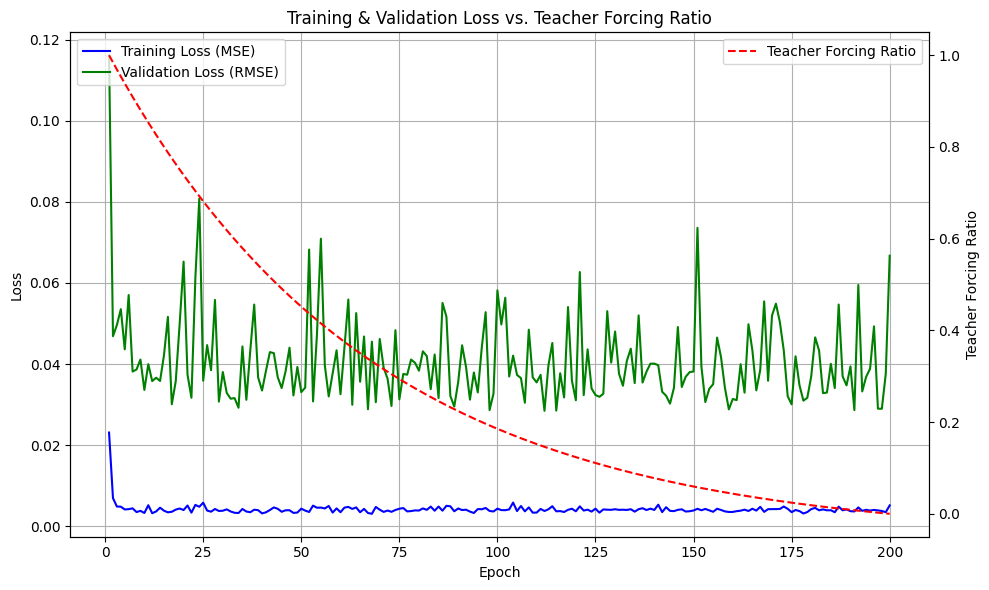

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import json
import os
import matplotlib.pyplot as plt

# Convert to numpy arrays
preds = np.array(test_predictions)
actuals = np.array(test_actuals)

# Compute metrics
mae = mean_absolute_error(actuals, preds)
rmse = np.sqrt(mean_squared_error(actuals, preds))
r2 = r2_score(actuals, preds)

print(f"\nTest Country Metrics:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

# Save metrics
test_country = target_country  # or whatever test country you're working with
metrics = {
    "country": test_country,
    "mae": mae,
    "rmse": rmse,
    "r2": r2
}

# os.makedirs("results", exist_ok=True)
# with open(f"results/metrics_{test_country}.json", "w") as f:
#     json.dump(metrics, f, indent=4)


import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot training and validation losses
ax1.plot(epochs, train_losses, label='Training Loss (MSE)', color='blue')
ax1.plot(epochs, val_losses, label='Validation Loss (RMSE)', color='green')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')
ax1.grid(True)

# Create a second y-axis for teacher forcing ratio
ax2 = ax1.twinx()
ax2.plot(epochs, teacher_forcing_ratios, label='Teacher Forcing Ratio', color='red', linestyle='--')
ax2.set_ylabel('Teacher Forcing Ratio')
ax2.legend(loc='upper right')

plt.title('Training & Validation Loss vs. Teacher Forcing Ratio')
plt.tight_layout()
plt.show()


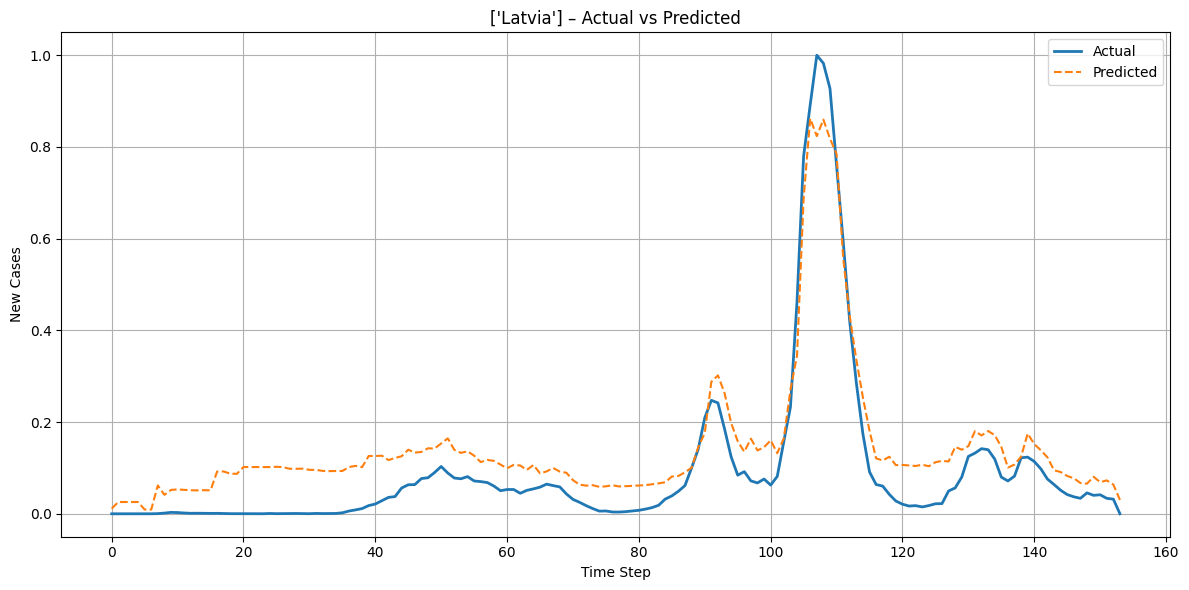

In [24]:
# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual', linewidth=2)
plt.plot(preds, label='Predicted', linestyle='--')
plt.title(f"{test_country} – Actual vs Predicted")
plt.xlabel("Time Step")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"results/prediction_plot_{test_country}.png")
plt.show()

# Simulations

In [25]:
def simulate_autoregressive_from_loader_v2(model, test_loader, start_idx, device):
    """
    Simulates autoregressive predictions starting from a given index,
    using real data before that point (warm start), and predictions afterwards.
    
    Returns normalized preds and actuals (not inverse transformed).
    """

    model.eval()

    # Convert DataLoader into full tensors
    X_endog_all, X_exog_all, y_all = [], [], []
    for X_endog, X_exog, y in test_loader:
        X_endog_all.append(X_endog)
        X_exog_all.append(X_exog)
        y_all.append(y)

    X_endog_all = torch.cat(X_endog_all, dim=0).to(device)  # (T, seq_len, num_endog_features)
    X_exog_all = torch.cat(X_exog_all, dim=0).to(device)
    y_all = torch.cat(y_all, dim=0).to(device)

    predictions = []

    actuals = y_all[start_idx:].cpu().numpy().reshape(-1, 1)

    seq_len = X_endog_all.shape[1]
    print(f"Sequence length: {seq_len}")

    # Warm start history: last sequence before start_idx
    endog_history = X_endog_all[start_idx - 1, :, 0].tolist()
    endog_history = endog_history[-seq_len:]

    for t in range(start_idx, len(X_exog_all)):
        recent_endog = endog_history[-seq_len:]
        recent_tensor = torch.tensor(recent_endog, dtype=torch.float32, device=device).view(1, seq_len, 1)
        current_exog = X_exog_all[t].unsqueeze(0)

        with torch.no_grad():
            pred = model(recent_tensor, current_exog)
            pred_value = max(pred.item(), 0.0)  # clamp to zero to avoid negatives
            predictions.append(pred_value)

        endog_history.append(pred_value)

    preds = np.array(predictions).reshape(-1, 1)

    return preds, actuals, y_all


Sequence length: 2


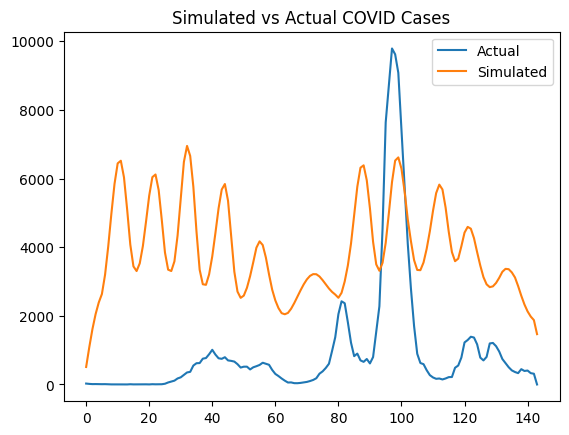

In [28]:
start_idx = 10
# or wherever your intervention begins
preds, actuals, y_all = simulate_autoregressive_from_loader_v2(model, test_loader, start_idx, device)
# scaler_X_test = MinMaxScaler()
# scaler_y_test = MinMaxScaler()
# Inverse transform if you have a scaler

preds = scaler_y_train.inverse_transform(preds)
actuals = scaler_y_train.inverse_transform(actuals)

import matplotlib.pyplot as plt
plt.plot(actuals, label='Actual')
plt.plot(preds, label='Simulated')
plt.legend()
plt.title("Simulated vs Actual COVID Cases")
plt.show()


In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Create time axis
full_length = start_idx + len(preds)
x_full = np.arange(full_length)

# Build a combined predictions array for plotting (with NaNs before start_idx)
preds_full = np.empty(full_length)
preds_full[:] = np.nan
preds_full[start_idx:] = preds

# Plot actual full series
plt.figure(figsize=(10, 5))
plt.plot(x_full, y_all[:full_length].cpu().numpy(), label='Actual')  # full actuals
plt.plot(x_full, preds_full, label='Simulated (AR from idx {})'.format(start_idx))

plt.axvline(start_idx, color='gray', linestyle='--', label='Intervention Start')
plt.legend()
plt.title("Simulated vs Actual COVID Cases with Warm Start")
plt.xlabel("Time")
plt.ylabel("Cases")
plt.tight_layout()
plt.show()


ValueError: could not broadcast input array from shape (144,1) into shape (144,)